### WGAN

* Модифицируйте код ячеек ниже и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (10 баллов)

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (10 баллов)

* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (30 баллов)

Добавьте в этот файл анализ полученных результатов с различными графиками обучения и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов и попробуйте пронаблюдать какие недостатки имеет модель GAN.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Простой конфиг (для хранения параметров, можете использовать и модифицировать)

In [2]:
class Config:
    pass

CONFIG = Config()
CONFIG.mnist_path = None
CONFIG.batch_size = 16
CONFIG.num_workers = 3
CONFIG.num_epochs = 10
CONFIG.noise_size = 50
CONFIG.print_freq = 500

### Создаем dataloader

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 10422374.23it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 295861.31it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5583656.71it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5048463.17it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)
len(dataloader)

3750

In [5]:
image, label = next(iter(dataloader))
image.size()

torch.Size([16, 1, 28, 28])

### Создаем модель GAN

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # config.noise_size = 50
            nn.Linear(CONFIG.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

In [7]:
generator = Generator()
discriminator = Discriminator()

In [8]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=200, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [9]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=200, out_features=50, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

### Оптимизатор и функция потерь

In [10]:
learning_rate = 0.0002
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

generator = generator.to(device)
discriminator = discriminator.to(device)
optim_G = optim.Adam(params=generator.parameters(), lr=learning_rate)
optim_D = optim.Adam(params=discriminator.parameters(), lr=learning_rate)

criterion = nn.BCELoss()

cpu


### Для оптимизации процесса обучения можно заранее определить переменные и заполнять их значения новыми данными

In [11]:
# noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device))
# # fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device).normal_(0, 1))
# label = Variable(torch.FloatTensor(config.batch_size, device=device))

noise_x = torch.empty(CONFIG.batch_size)
print(noise_x)
# noise must be 50 x 200
# noise = torch.tensor(noise_x, dtype=torch.float, device=torch.device(device))

# DEFAULT LINE
noise = Variable(torch.FloatTensor(CONFIG.batch_size, CONFIG.noise_size, device=device))
# fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device).normal_(0, 1))

noise_y = torch.empty(CONFIG.batch_size)
# label = torch.tensor(noise_y, dtype=torch.float, device=torch.device(device))

# DEFAULT LINE
label = Variable(torch.FloatTensor(CONFIG.batch_size, device=device))


real_label = 1
fake_label = 0

tensor([2.1707e-18, 7.0952e+22, 1.7748e+28, 1.8176e+31, 7.2708e+31, 5.0778e+31,
        3.2608e-12, 1.7728e+28, 7.0367e+22, 2.1715e-18, 1.0514e-05, 8.2651e-10,
        4.1263e-08, 1.0488e-08, 7.9873e+20, 1.2915e-11])


In [12]:
noise

tensor([[ 1.7419e+33,  4.5825e-41,  1.7419e+33,  4.5825e-41,  2.0812e+35,
          3.3087e-41,  2.0812e+35,  3.3087e-41,  2.0818e+35,  3.3087e-41,
          0.0000e+00,  0.0000e+00,  1.5669e+35,  3.3087e-41,  5.8287e+33,
          3.3087e-41, -1.6361e-31,  4.5824e-41,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.4013e-45,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          5.6052e-45,  0.0000e+00,  1.4013e-45,  0.0000e+00,  9.1844e-41,
          1.1551e-40,  4.5919e-41,  8.2957e-43,  9.8434e+32,  4.5825e-41],
        [ 2.0865e-42,  0.0000e+00,  1.7418e+33,  4.5825e-41,  1.7418e+33,
          4.5825e-41,  2.0812e+35,  3.3087e-41,  2.0812e+35,  3.3087e-41,
          6.7262e-44,  0.0000e+00,  4.0357e-43,  0.0000e+00,  5.6889e-35,
          4.5825e-41,  8.3284e+31,  4

In [13]:
label

tensor([1.7417e+33, 4.5825e-41, 1.8636e+35, 3.3087e-41, 1.4013e-45, 0.0000e+00,
        2.0797e+35, 3.3087e-41, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0795e+35, 3.3087e-41, 5.8287e+33, 3.3087e-41])

### GAN обучение

In [14]:
ERRD_x = np.zeros(CONFIG.num_epochs)
ERRD_z = np.zeros(CONFIG.num_epochs)
ERRG = np.zeros(CONFIG.num_epochs)
N = len(dataloader)

for epoch in range(CONFIG.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(device)
        output = discriminator(input_data).view(-1)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % CONFIG.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 500 errD_x: 0.05 errD_z: 0.04 errG: 3.55
Epoch:1 Iter: 1000 errD_x: 0.05 errD_z: 0.06 errG: 4.65
Epoch:1 Iter: 1500 errD_x: 0.02 errD_z: 0.02 errG: 4.92
Epoch:1 Iter: 2000 errD_x: 0.42 errD_z: 0.05 errG: 3.02
Epoch:1 Iter: 2500 errD_x: 0.11 errD_z: 0.05 errG: 3.87
Epoch:1 Iter: 3000 errD_x: 0.11 errD_z: 0.13 errG: 2.12
Epoch:1 Iter: 3500 errD_x: 0.06 errD_z: 0.19 errG: 2.55
Epoch:2 Iter: 500 errD_x: 0.07 errD_z: 0.03 errG: 4.48
Epoch:2 Iter: 1000 errD_x: 0.14 errD_z: 0.02 errG: 4.67
Epoch:2 Iter: 1500 errD_x: 0.12 errD_z: 0.09 errG: 3.19
Epoch:2 Iter: 2000 errD_x: 0.30 errD_z: 0.02 errG: 3.85
Epoch:2 Iter: 2500 errD_x: 0.39 errD_z: 0.21 errG: 2.79
Epoch:2 Iter: 3000 errD_x: 0.23 errD_z: 0.05 errG: 4.04
Epoch:2 Iter: 3500 errD_x: 0.19 errD_z: 0.06 errG: 3.69
Epoch:3 Iter: 500 errD_x: 0.52 errD_z: 0.24 errG: 2.91
Epoch:3 Iter: 1000 errD_x: 0.56 errD_z: 0.03 errG: 3.06
Epoch:3 Iter: 1500 errD_x: 0.53 errD_z: 0.07 errG: 3.38
Epoch:3 Iter: 2000 errD_x: 0.32 errD_z: 0.33 errG: 

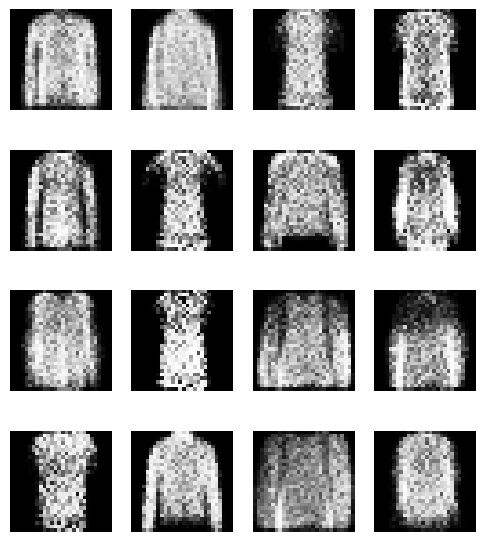

In [15]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')